<a href="https://colab.research.google.com/github/comparativechrono/Rephasing-of-Seasonal-Birth-Rates-in-the-United-Kingdom-/blob/main/Figures/FIGURE_4_REVISED.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

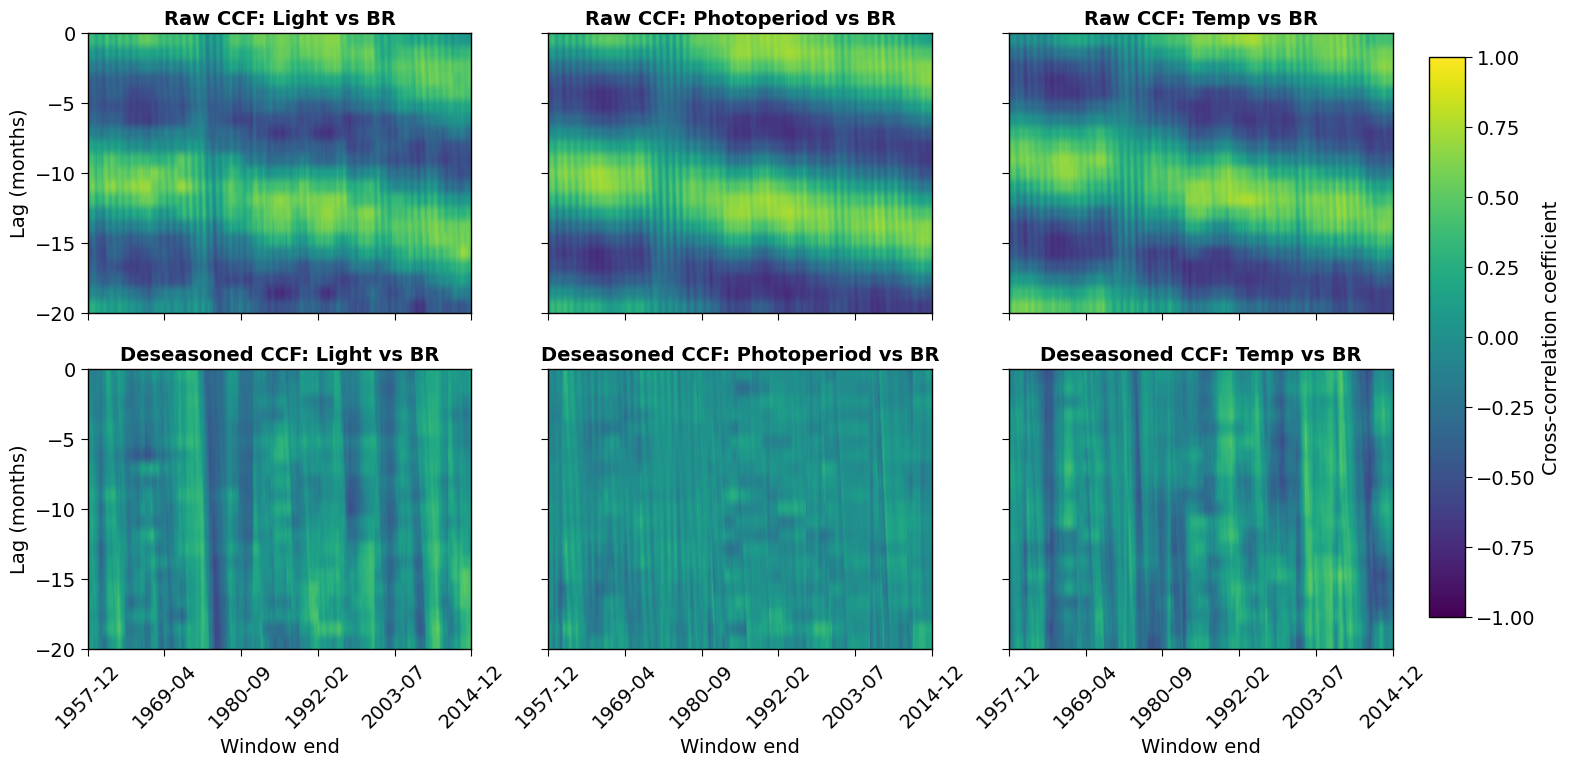

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from statsmodels.tsa.seasonal import STL
from scipy.stats import t as t_dist

# Load and parse dataset
df = pd.read_csv('environmental.csv')
def parse_date_two_digit(s):
    month_str, year_str = s.split('-')
    month = datetime.strptime(month_str, '%b').month
    y = int(year_str)
    year = y + 2000 if y <= 25 else y + 1900
    return pd.Timestamp(year=year, month=month, day=1)
df['Date'] = df['Date'].apply(parse_date_two_digit)
df.set_index('Date', inplace=True)

# Settings
env_vars = ['light', 'photoperiod', 'temp']
window = 60
max_lag = 20
lags = np.arange(-max_lag, 1)
n_windows = len(df) - window + 1
dates = df.index[window - 1:]

# Helper: compute CCF matrix for given series
def compute_ccf_matrix(x_series, y_series, lags):
    mat = np.full((len(lags), n_windows), np.nan)
    for i in range(n_windows):
        win_x = x_series[i:i + window]
        win_y = y_series[i:i + window]
        for j, lag in enumerate(lags):
            if lag >= 0:
                x = win_x[lag:]
                y = win_y[:window - lag]
            else:
                x = win_x[:window + lag]
                y = win_y[-lag:]
            if len(x) > 2:
                mat[j, i] = np.corrcoef(x, y)[0, 1]
    return mat

# Raw CCF matrices
raw_matrices = {var: compute_ccf_matrix(df[var].values, df['BR'].values, lags) for var in env_vars}

# Deseasonalize only seasonal via STL
df_deseason = pd.DataFrame(index=df.index)
for col in env_vars + ['BR']:
    stl = STL(df[col], period=12, robust=True)
    res = stl.fit()
    df_deseason[col] = df[col] - res.seasonal

# Deseason CCF matrices
des_matrices = {var: compute_ccf_matrix(df_deseason[var].values, df_deseason['BR'].values, lags) for var in env_vars}

# Assuming raw_matrices, des_matrices, dates, lags, env_vars are already defined

fig, axes = plt.subplots(2, len(env_vars), figsize=(18, 8), sharex=True, sharey=True, facecolor='white')

for idx, var in enumerate(env_vars):
    # Raw CCF heatmap
    ax = axes[0, idx]
    im = ax.imshow(
        raw_matrices[var],
        aspect='auto',
        origin='lower',
        cmap='viridis',       # diverging colormap
        vmin=-1,
        vmax=1,
        extent=[dates[0].toordinal(), dates[-1].toordinal(), lags[0], lags[-1]]
    )
    ax.set_title(f'Raw CCF: {var.capitalize()} vs BR')
    if idx == 0:
        ax.set_ylabel('Lag (months)')
    ax.set_xticks([])

    # Deseasoned CCF heatmap
    ax = axes[1, idx]
    im2 = ax.imshow(
        des_matrices[var],
        aspect='auto',
        origin='lower',
        cmap='viridis',
        vmin=-1,
        vmax=1,
        extent=[dates[0].toordinal(), dates[-1].toordinal(), lags[0], lags[-1]]
    )
    ax.set_title(f'Deseasoned CCF: {var.capitalize()} vs BR')
    if idx == 0:
        ax.set_ylabel('Lag (months)')
    ax.set_xlabel('Window end')
    xticks = pd.date_range(dates[0], dates[-1], periods=6)
    ax.set_xticks(xticks.map(lambda d: d.toordinal()))
    ax.set_xticklabels(xticks.strftime('%Y-%m'), rotation=45)

# Make room on the right for a single shared colorbar
fig.subplots_adjust(right=0.85)

# Add one colorbar for all subplots
cbar_ax = fig.add_axes([0.87, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
fig.colorbar(im, cax=cbar_ax, label='Cross-correlation coefficient')

plt.show()
